In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

/home/rainorangelemon/Documents/tiny-diffusion


/home/rainorangelemon/micromamba/envs/robodiff/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# run the following command in the tmux
# !python ddpm.py --experiment_name composition_product_1 --dataset composition_product_1 --input_embedding identity --hidden_layers 4 --num_epochs 1000 --mlp_type energy
# !python ddpm.py --experiment_name composition_product_2 --dataset composition_product_2 --input_embedding identity --hidden_layers 4 --num_epochs 1000 --mlp_type energy

In [3]:
import torch
import ddpm
model_1 = ddpm.EnergyMLP(
    hidden_layers=4,
    input_emb='identity')

model_2 = ddpm.EnergyMLP(
    hidden_layers=4,
    input_emb='identity')

model_1.load_state_dict(torch.load("exps/composition_product_1/model.pth"))
model_2.load_state_dict(torch.load("exps/composition_product_2/model.pth"))

/home/rainorangelemon/micromamba/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [4]:
from tqdm.auto import tqdm
import numpy as np
eval_batch_size = 1
num_timesteps = 50
plot_step = 5
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
# sample = torch.randn(eval_batch_size, 2)
sample = torch.tensor([[3.3967, -2.5607]])
timesteps = list(range(num_timesteps))[::-1]
samples = []
steps = []
for i, t in enumerate(tqdm(timesteps)):
    for _ in range(1):
        t_tensor = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
        with torch.no_grad():
            residual = model_1(sample, t_tensor) #+ model_2(sample, t_tensor)) / 2
        sample = noise_scheduler.step(residual, t_tensor[0], sample)
    if (i + 1) % plot_step == 0:
        samples.append(sample.numpy())
        steps.append(i + 1)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 425.27it/s]


In [13]:
# hmc sampling

import mcmc
from tqdm.auto import tqdm
import numpy as np
eval_batch_size = 8000
num_timesteps = 50
plot_step = 5

epsilon = 0.03
L = 3
HMC_STEP = 0

# model_1.to('cuda:0')
# model_2.to('cuda:0')

model_to_test = model_1
# model_to_test = ddpm.CompositionEnergyMLP(model_1, model_2, algebra='product')

sample = torch.randn(eval_batch_size, 2).float().numpy()
# sample = torch.tensor([[3.3967, -2.5607]])
eval_batch_size = len(sample)
timesteps = list(range(num_timesteps))[::-1]
samples = []
steps = []
for i, t in enumerate(tqdm(timesteps)):

    t_tensor = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        x = torch.tensor(sample).float()
        residual = model_to_test(x, t_tensor)
    sample = noise_scheduler.step(residual, t_tensor[0], x).detach().cpu().numpy()

    def logp(x): 
        x = torch.tensor(x).float()
        # t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
        return model_to_test.energy(x, t_tensor).detach().cpu().numpy()
    
    def grad_logp(x):
        x = torch.tensor(x).float()
        # t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
        return model_to_test(x, t_tensor).detach().cpu().numpy()    
    
    for _ in range(HMC_STEP):
        sample, _ = mcmc.hmc(logp, grad_logp, sample, epsilon, L)
    if (i + 1) % plot_step == 0:
        samples.append(sample)
        steps.append(i + 1)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 61.66it/s]


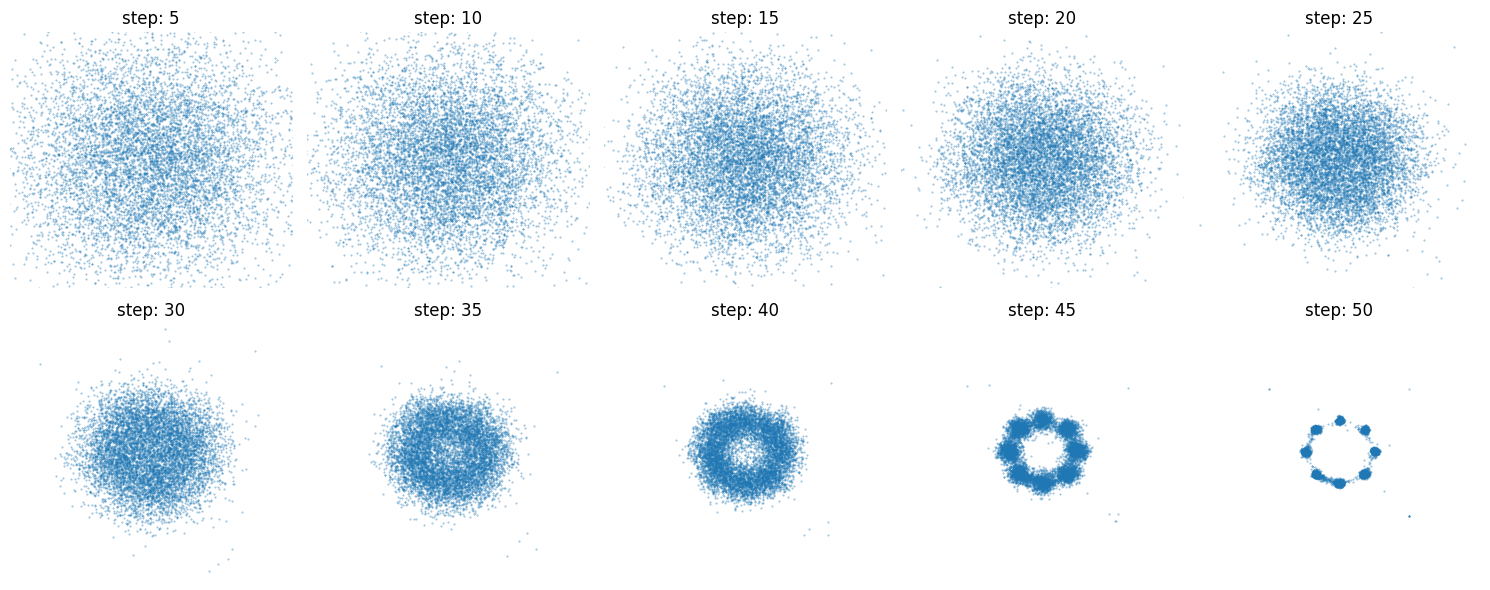

In [14]:
import matplotlib.pyplot as plt
import math
plt.clf()
plt.close('all')
num_cols = 5
num_rows = math.ceil(len(samples) / num_cols)
fig = plt.figure(figsize=(15, 6))
for i, sample in enumerate(samples):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=0.2)
    plt.title(f"step: {steps[i]}")
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.axis("off")
fig.tight_layout()
plt.savefig('figures/composition_long_hmc.png')

In [1]:
# draw the energy landscape
import matplotlib.pyplot as plt
import numpy as np

plt.clf()
plt.close('all')
for t in range(50, -1, -1):
    # meshgrid the space
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    Z = model_to_test.energy(torch.tensor(np.stack([X, Y], axis=-1).reshape(-1, 2)).float(),t+torch.zeros(10000).long()).detach().cpu().numpy().reshape(100, 100)
    plt.figure(figsize=(6, 6))
    plt.contourf(X, Y, Z, levels=10)
    plt.colorbar()

plt.clf()
plt.close('all')

NameError: name 'model_to_test' is not defined